In [1]:
#импортируем библиотеки для работы
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# Тема: поиск причин убыточности рекламной кампании развлекательного приложения

##   Шаг 1. Загрузим данные и подготовим их к анализу

In [2]:
# загрузим данные о визитах заказах и расходах
visits = pd.read_csv('/datasets/visits_info_short.csv') 
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
#посмотримна фреймы
frame = {"visits_frame":visits,
         "orders_frame":orders,
         "costs_frame":costs
        }  #создадим словарь для того, чтобы можно было по нему пробежаться

for name, information in frame.items():
    display(name.upper())
    display(
        information.head(),   #открываем фрейм
        information.info(), #выводем информацию о фрейме
        information.isna().sum(), #посмотрим на пропуски
        information.duplicated().sum() #выведем явные дубликаты для изучения
    ) 
    

'VISITS_FRAME'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


None

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

0

'ORDERS_FRAME'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


None

User Id     0
Event Dt    0
Revenue     0
dtype: int64

0

'COSTS_FRAME'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


None

dt         0
Channel    0
costs      0
dtype: int64

0

In [4]:
for name, low_columns in frame.items():  
    low_columns.columns = low_columns.columns.str.lower() # привидем название столбцов к нижнему регистру
    
visits = visits.rename(columns={    # приведем название столбцов к змеиному регистру
            'user id': 'user_id',
            'session start': 'session_start',
            'session end': 'session_end',
            })
orders = orders.rename(columns={'user id': 'user_id',
                                'event dt': 'event_dt'})

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start']) #приведем к формату datetime
visits['session_end'] = pd.to_datetime(visits['session_end']) #приведем к формату datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt']) #приведем к формату datetime


costs['dt'] =  pd.to_datetime(costs['dt']).dt.date #объект для нормального мержирования

**Вывод**

1) Привели название столбцов к змеиному и нижнему регистру.

2) Дубликатов не найдено.

3) Пропусков не найдено.

## Создадим функции для расчета и анализа LTV, ROI, удержания и конверсии

In [6]:
# напишем функцию для создания пользовательских профилей с датой первого посещения и источником перехода

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [7]:
# напишем функцию для расчета удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [8]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [10]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [12]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [13]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()


##  Проведем исследовательский анализ данных

Построим профили пользователей. Определим минимальную и максимальную дату привлечения пользователей.

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [14]:
profiles = get_profiles(visits, orders, costs) #зададим данные для функции профилей
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [15]:
min_analysis_date = profiles['dt'].min() #минимальная даты привлечения пользователей
observation_date = profiles['dt'].max() #минимальная даты привлечения пользователей(момент анализа)
print([min_analysis_date, observation_date]) #даты с техзаданием сходятся

[datetime.date(2019, 5, 1), datetime.date(2019, 10, 27)]


**Узнаем, из каких стран приходят поситители  и в каких из них большего всего платящих пользователей:**

Так как перед нами стоят три похожие задачи, которые выполняются на идентичном коде, чтобы не плодить код запишем его в функцию и будем задавать аргументы по надобности:

In [16]:
def analysis (df, table): #1) аргумент с датафреймом 2) аргумент со столбцом из датафрейма
    
    # считаем количествто по группировке
    quantity = (df
                .groupby(table) #группируем по нужному столбцу
                .agg({table: 'count'})
                .rename(columns={table: 'quantity'})
                .sort_values(by='quantity', ascending = False)
                
               )
    # считаем количесвто платящих
    quantity_of_payers = (df
                .query('payer == True') #выберем платящих пользователей
                .groupby(table) #группируем по нужному столбцу
                .agg({'payer': 'count'})
                .rename(columns={'payer': 'paying_users'})
                .sort_values(by='paying_users', ascending = False)
                
               )
    
    quantity = quantity.merge(quantity_of_payers, on=table, how='left')
    quantity['ratio_of_paying,%'] = (quantity['paying_users']/quantity['quantity']*100)  
    quantity = quantity.style.format({'ratio_of_paying,%': '{:.2f}%'})
    
    return quantity

In [17]:
#вызовем таблицу по странам
number_of_region = analysis (profiles, 'region')
number_of_region

,quantity,paying_users,"ratio_of_paying,%"
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


Из таблицы видно, что больше всего пользователей приходят из США, так же показатель отношения платящих пользователей к обычным пользователям самый высокий именно в этой стране и составляет 6,9%.

Среди пользователей из Соединенного Королевства к платящим пользователей относятся 3,98% (700 платящих пользователей) от общего количества пользователей в этой стране (17575 человек).

Среди пользователей из Франции к платящим пользователям относятся 3.80% (663 платящих пользователей). Общее количество пользователей в этой стране составляет 17450 человек.

Среди пользователей из Германии к платящим пользователям относятся 4.11% (616 платящих пользователей) от общего количества пользователей в этой стране (14981 человек).


**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:**

In [18]:
#вызовем таблицу по девайсам
number_of_device = analysis (profiles, 'device')
number_of_device

,quantity,paying_users,"ratio_of_paying,%"
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


Самое большое количество пользователей заходят с iPhone: 54479 пользователей, 3382	из которых "платящие", что составляет 6.21%.

Второе по популярности  устройство является Android: 35032 пользователей, 2050	 из которых "платящие", что составляет 5.85%.

Следом по популярности идет PC. С персонального компьютера заходят 30455 пользователей, 1537 из которых "платящие", что составляет 5.05%.

Наименее популярным устройством по количеству пользователей является Mac 30042 пользователей. Платящих пользователей 1912, что составляет 6.36% от общего количества пользователей данного устройства. Самый лучший показатель по отношению платящих клиентов к общему числу пользователей устройства.

Итак, платящие пользователи предпочитают следующие устройства: Mac 6.36% -платящих пользователей, iPhone - 6.21%,  Android - 5.85%,  PC - 5.05%.	

**Узнаем, по каким рекламным каналам шло привлечение пользователей и какие из них приносят больше всего платящих пользователей**

In [19]:
number_of_channel = analysis (profiles, 'channel')
number_of_channel

,quantity,paying_users,"ratio_of_paying,%"
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


Большего всего платящих пользователей приходят с FaceBoom(12.20% платящих от общего числа пришедших), AdNonSense(11.34%) и lambdaMediaAds (10.47%). Меньше всего платящих пользователей пришло с каналов MediaTornado(3.57%), LeapBob (3.06%), и OppleCreativeMedia(2.71%).

In [20]:
(profiles #посмотрим какие основные каналы привлечения были в разных странах
 .pivot_table(index='channel', columns ='region', values='user_id', aggfunc='count')
 .reset_index()
)

region,channel,France,Germany,UK,United States
0,AdNonSense,1366.0,1219.0,1295.0,NaN
1,FaceBoom,NaN,NaN,NaN,29144.0
2,LeapBob,2988.0,2519.0,3046.0,NaN
3,MediaTornado,NaN,NaN,NaN,4364.0
4,OppleCreativeMedia,2991.0,2562.0,3052.0,NaN
5,RocketSuperAds,NaN,NaN,NaN,4448.0
6,TipTop,NaN,NaN,NaN,19561.0
7,WahooNetBanner,2971.0,2579.0,3003.0,NaN
8,YRabbit,NaN,NaN,NaN,4312.0
9,lambdaMediaAds,742.0,649.0,758.0,NaN


В США основным каналом привлечения является FaceBoom (29144 пользователей), на второй позиции находится TipTop (19561 пользователей).

В Великобритании - OppleCreativeMedia (3052 пользователей), затем LeapBob (3046 пользователей).

В Германии - WahooNetBanner (2579 пользователей), OppleCreativeMedia (2562 пользователей)
Во Франции - LeapBob (2988 пользователей),  OppleCreativeMedia (2991 пользователей).

In [21]:
(profiles #посмотрим какие основные девайсы используют пользователи в разных странах
 .pivot_table(index='device', columns ='region', values='user_id', aggfunc='count')
 .reset_index()
)

region,device,France,Germany,UK,United States
0,Android,5252,4440,5141,20199
1,Mac,1838,1584,1778,24842
2,PC,6940,5945,7138,10432
3,iPhone,3420,3012,3518,44529


Основными девайсами в США являются iPhone и Mac, в Великобритании - PC, Android, в Германии - PC, Android и Франции - PC, Android.

**Вывод**

1) Большинство пользователей пришло в приложение из США (100002 человек). Далее, в порядке убывания по количеству пользователей идут следующие страны: Великобритания - 17575 человек, Франция - 17450 человек и Германия - 14981 человек.

Однако, рейтинг отношения платящих клиентов ко всем пользователям по региону выглядит следующем образом: США - 6,9%%, Германия - 4.11%, Великобритания - 3,98% и Франция - 3.80%.

2) Самое большое количество пользователей заходят с iPhone - 54479 пользователей, второе по популярности  устройство является Android - 35032 пользователей, следом по популярности идет PC - 30455 пользователей, на последнем месте по популярности устройства идет Mac - 30042  пользователей.

Рейтинг долей платящих клиентов по устройствам выглядит следующим образм: Mac 6.36% -платящих пользователей, iPhone - 6.21%, Android - 5.85%, PC - 5.05%.

3) Наибольшее число платящих пользователей пришло с FaceBoom(12.20% платящих от общего числа пришедших), AdNonSense(11.34%) и lambdaMediaAds (10.47%). Наихудшие результаты принадлежат каналам MediaTornado(3.57%), LeapBob (3.06%), и OppleCreativeMedia(2.71%).

4) В США основным каналом привлечения является FaceBoom и TipTop. В Великобритании - OppleCreativeMedia и LeapBob. В Германии - WahooNetBanner и OppleCreativeMedia.
Во Франции - LeapBob и OppleCreativeMedia.

5) Основными девайсами в США являются iPhone и Mac, в Великобритании - PC, Android, в Германии - PC, Android и Франции - PC, Android.

##  Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

**Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.**

Посчитаем сколько всего потрачено на маркетинг:

In [22]:
total_spending = profiles['acquisition_cost'].sum() 
display(f'Вcего потрачено на рекламу {total_spending.round(2)}')

'Вcего потрачено на рекламу 105497.3'

Посмотрим описание рекламных расходов:

In [23]:
costs['costs'].describe() #описание по дням

count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Из описания видно, что минимальные вложения в рекламу за день были 0,8 у.е, а максимальные 630 у.е. А средняя стоимость рекламной кампании за изучаемый интревал времени составляет 58.61 у.е.

Узнаем, сколько было потрачено на маркетинг из каждого источника:

In [24]:
ad_cost = (profiles
           .groupby('channel') 
           .agg({'acquisition_cost': 'sum'})
           .rename(columns={'acquisition_cost': 'marketing_costs'})
           .sort_values(by='marketing_costs', ascending = False)
           .reset_index()
          )
ad_cost['ratio'] = (ad_cost['marketing_costs']/total_spending*100)
ad_cost.style.format({'ratio': '{:.2f}%'})

,channel,marketing_costs,ratio
0,TipTop,54751.300000,51.90%
1,FaceBoom,32445.600000,30.75%
2,WahooNetBanner,5151.000000,4.88%
3,AdNonSense,3911.250000,3.71%
4,OppleCreativeMedia,2151.250000,2.04%
5,RocketSuperAds,1833.000000,1.74%
6,LeapBob,1797.600000,1.70%
7,lambdaMediaAds,1557.600000,1.48%
8,MediaTornado,954.480000,0.90%
9,YRabbit,944.220000,0.90%


Из таблицы видно, что тройка лидеров (в порядке убывания) по рекламным вливаниям выглядит следующим образом: TipTop - затраты составили 54751.30 у.е., что составляет 51.90% от всего рекламного бюджета, FaceBoom - затраты составили 32445.60 у.е. (30.75% от рекламного бюджета) и WahooNetBanner - 5151.00 у.е., всего 4.88% от рекламного бюджета.

Замыкающая тройка с минимальными расходами выглядит следующим образом: lambdaMediaAds - 1557.60 у.е. (1.48% от рекламного бюджета), MediaTornao - 954.48 у.е. (0.90%) и YRabbit - 944.22 у.е. (0.90%).

Выведем график изменения расходов на маркетинг по дням:

Для визуализации затрат на рекламу для начала сгруппируем расходы по дням:

In [25]:
cbd = (costs
       .groupby('dt')
       .agg({'costs':'sum'})
       .reset_index()
      )
cbd.describe()

,costs
count,180.000000
mean,586.096111
std,197.289593
min,230.380000
25%,414.960000
50%,597.810000
75%,708.213750
max,1075.485000


Визуализируем изменение расходов на маркетинг по дням:

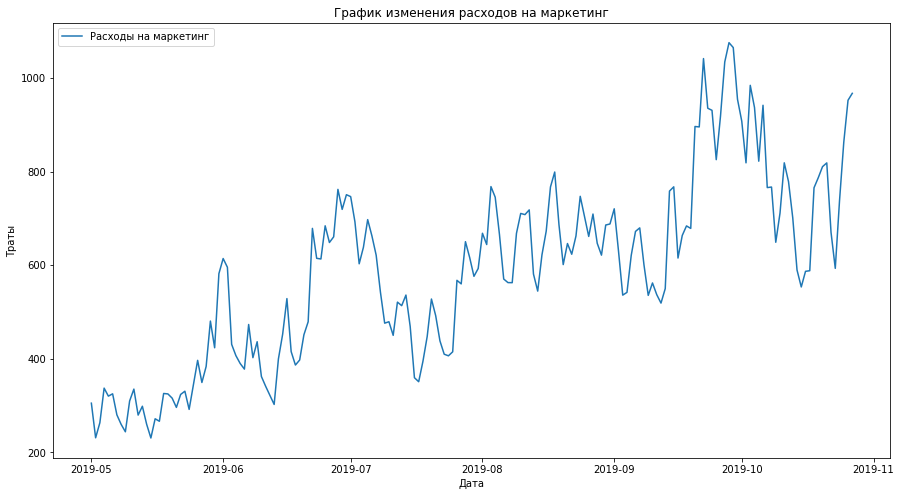

In [26]:
cbd.plot(y='costs',
         x='dt',
         figsize=(15, 8),
         label='Расходы на маркетинг',
         legend=True)
           
plt.title('График изменения расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

На графике видно, что общий тренд расходов на рекламные кампании увеличивается. Минимальная сумма, которую вкладывали на маркетинг в день за изучаемый период составляет 230.38 у.е., максимальные дневные затраты составляют 1075.48 у.е.

In [27]:
cost_by_channel = (costs
                   .pivot_table(index='dt', 
                                columns='channel', 
                                values='costs',
                                aggfunc='mean')
                   .round(2) 
)

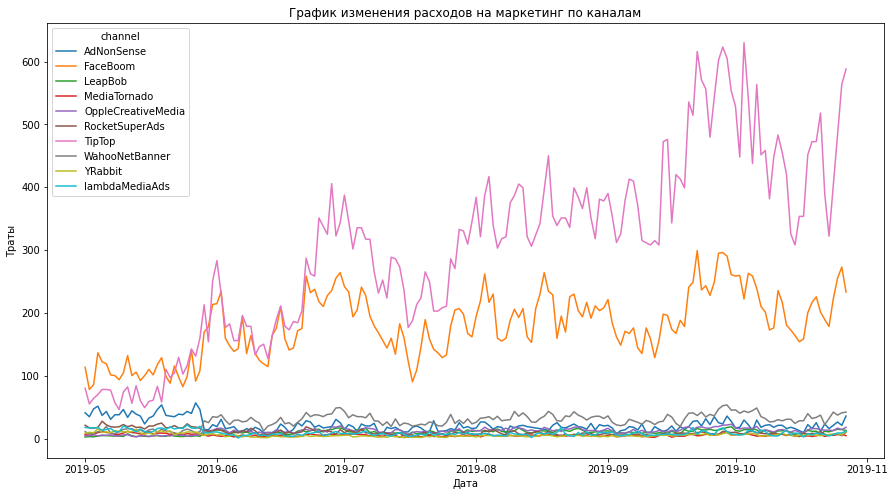

In [28]:
cost_by_channel.plot(
    figsize=(15, 8),
    label='Расходы на маркетинг',
    legend=True
)
          
plt.title('График изменения расходов на маркетинг по каналам')
plt.xlabel('Дата')
plt.ylabel('Траты')
plt.show()

Из графика видно, что основная масса расходов трат по каналам является стабильной и только два канала выбиваются постоянным увеличением расходов на маркетинг. Самое большое увеличение рекламного бюджета принадлежит TipToр. Второй канал, который отличается стабильным приростом расходов на маркетинг - FaceBoom.


То есть тот прирост, который мы могли видеть на графике общего изменения рекламного бюджета по дням, давали две компании, на которые регулярно увеличивали бюджет - TipToр, FaceBoom.

**Узнайтем, сколько в среднем стоило привлечение одного пользователя из каждого источника.**

Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика:

In [29]:
profiles['acquisition_cost'].describe() #средняя стоимость привлечения на одного пользователя для всего проекта

count    150008.000000
mean          0.703278
std           0.954097
min           0.000000
25%           0.000000
50%           0.247500
75%           1.108943
max           3.715385
Name: acquisition_cost, dtype: float64

Итак, средння стоимость привлечения пользователя составляет 1.13 у.е.

Расчитаем стоимость привлечения одного пользователя по каналам:

In [30]:
cac_by_channel = (profiles
                .groupby('channel')
                .agg({'acquisition_cost': 'mean'})
                .sort_values(by='acquisition_cost', ascending=False)
                .round(2)
                .reset_index()
                #.style.hide_index()
               )
cac_by_channel

,channel,acquisition_cost
0,TipTop,2.80
1,FaceBoom,1.11
2,AdNonSense,1.01
3,lambdaMediaAds,0.72
4,WahooNetBanner,0.60
5,RocketSuperAds,0.41
6,OppleCreativeMedia,0.25
7,YRabbit,0.22
8,MediaTornado,0.22
9,LeapBob,0.21


Самая большая стоимость привлечения одного пользователя приходится на TipTop и равна 2.80 у.е. На второй строчке разместился FaceBoom со стоимостью привлечения пользователя равной 1.11 у.е. и на третьем месте AdNonSense - 1.01 у.е. Тройка "дешевых" пользователей выглядит следующим образом:  YRabbit-0.22 у.е., MediaTornado 0.22 у.е и LeapBob - 0.21 у.е.

Посмотрим как изменяется цена привлечения одного пользователя по каналам. Для этого создадим сводную таблицу и выведем график по ней:

In [31]:
day_cac_by_channel = (
    profiles
    .pivot_table(index='dt', 
                 columns='channel', 
                 values='acquisition_cost',
                 aggfunc='mean')
    .round(2) 
)

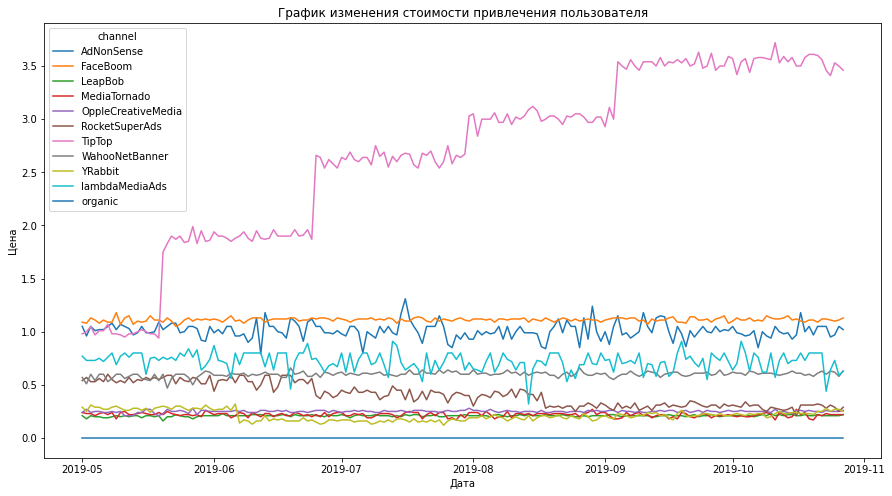

In [32]:
day_cac_by_channel.plot(
    figsize=(15, 8),
    label='Расходы на маркетинг',
    legend=True
)
          
plt.title('График изменения стоимости привлечения пользователя')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

Интересно, стоимость привлечения одного клиента по всем источникам приблизительно стабильная, а вот цена пользователя из TipTop постоянно и стремительно растет. Причем рост происходит скачкообразный в определенные дни, возможно это связано с изменением ценовой политики  TipTop.

**Вывод:**

1) За изучаемый период было потрачено на рекламу 105497.30 у.е. 

2) Тройка лидеров по объему вливания рекламного бюджета выглядит следующим образом: TipTop - забирает 51.90% от всего рекламного бюджета, FaceBoom - 30.75% и WahooNetBanner - всего 4.88% от рекламного бюджета.

3) За изучаемый интервал времени тренд общих расходов на рекламные кампании увеличивается с первого дня. 

4) Увеличение расходов на рекламные кампании связано с постоянным увеличением трат на два сервиса - TipToр и FaceBoom. Траты на другие компании является стабильными, держащиеся в одном диапазоне.

5) Средняя стоимость привлечения одного пользователя составляет 1.13 у.е.

6) Самые дорогие пользователи приходят из TipTop стоимость пользователя 2.80 у.е., FaceBoom - 1.11 у.е., AdNonSense - 1.01 у.е. Тройка "дешевых" пользователей выглядит следущем образом: YRabbit - 0.22 у.е., MediaTornado - 0.22 у.е и LeapBob - 0.21 у.е.

7) Стоимость привлечения одного клиента по всем источникам приблизительно стабильная, а вот цена привлечения пользователя из TipTop постоянно и стремительно растет.


## Оценим окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируем общую окупаемость рекламы;
- Проанализируем окупаемость рекламы с разбивкой по устройствам;
- Проанализируем окупаемость рекламы с разбивкой по странам;
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам.

Опишим проблемы, которые обнаружили. Ответим на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

### Проанализируем общую окупаемость рекламы

In [33]:
#исключим пользователей с органическим трафиком так как мы изучаем эффективность рекламы
profiles = profiles.query('channel != "organic"')

Проанализируем общую окупаемость рекламы:

In [34]:
horizon_days = 14  # горизонт анализа 
observation_date # момент анализа

datetime.date(2019, 10, 27)

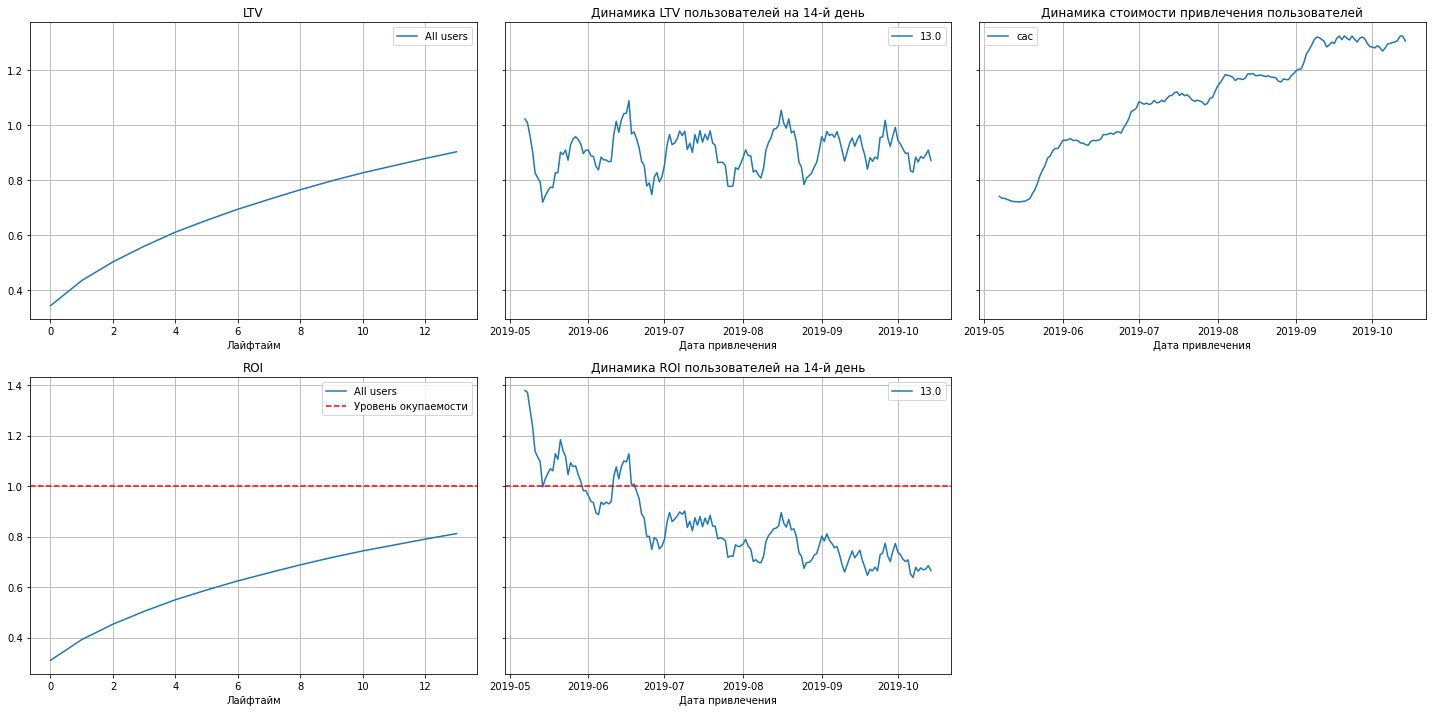

In [35]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По полученным графикам можно сделать выводы:

1) Реклама не окупается. К концу второй недели ROI 81%. Рекламные кампании приносят убыток.

2) Реклама окупалась до середины июля, затем окупаемость начала стремительно падать

3) CAC не стабилен. Стоимость привлечение пользователей стремительно растет начиная с середины мая

4) LTV имеет колебания в определенном канале, но все довольно стабильно

Для того, чтобы определить причину по которой реклама не окупается изучим окупаемость с разбивкой по устройствам, по регионам и рекламным каналам.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

Изучим окупаемость рекламы по используемым устройствам пользователей:

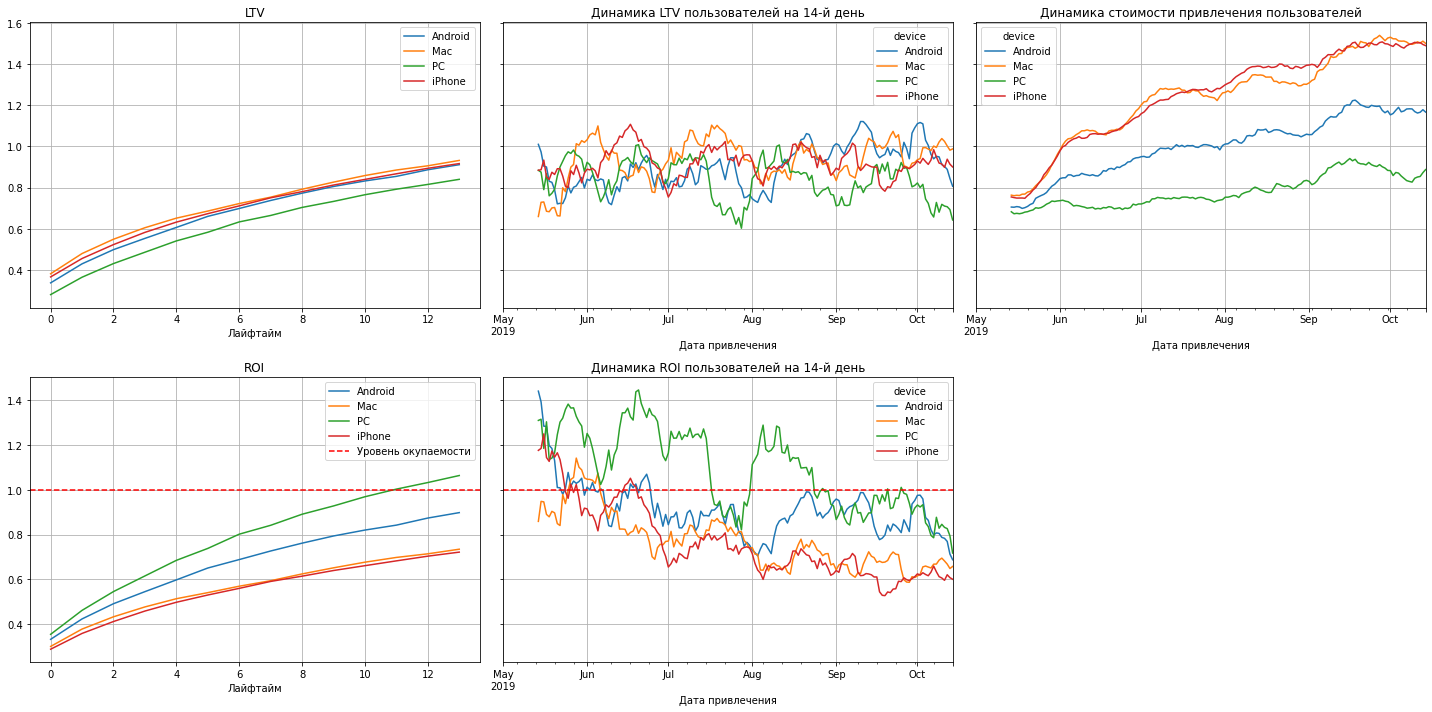

In [36]:
dimensions = ['device'] 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

На графиках видно следующее:

1) Владельцы персональных компьютеров окупаются, а вот обладатели продукции от компании Apple (Mac и iphone) и Android, тянут результаты рекламных кампаний вниз. Реклама привлекшая пользователей на PC откупается с показателем 106%, пользователи Android не окупаются, значение окупаемости 90%, Iphone и Mac так же не окупаются с показателями 72% и 73% соответсвенно. 

2) Пользователи, привлеченные на персональных компьютерах в среднем окупаются за исключением интервала с середины июля по август, с сентября реклама перестала окупаться. Пользователи на Android и Iphone перестают окупаться в конце мая - начале июня месяце. Пользователи Mac не окупались практически никогда.

Узнаем, в чём причина: в низкой конверсии или низком удержании.

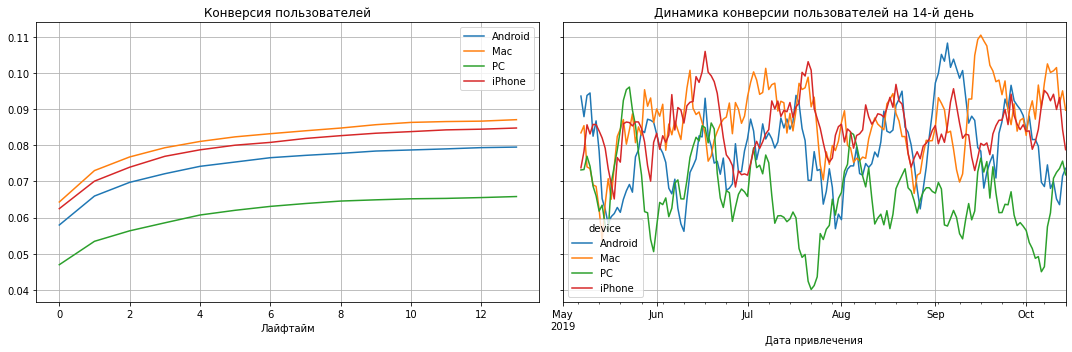

In [37]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Как видно из графика пользователи на всех устройствах конвертируются очень хорошо. Самое минимальное значение конверсии у пользователей персональных компьютеров и составляет 6,6%, затем идут обладатели Android с конверсией в 7,9%, следом IPhone - 8.5% и Mac - 8,7%. Видимо, дело в удержании. Вызовем функции get_retention() и plot_retention(), чтобы рассчитать и отразить на графиках этот показатель.

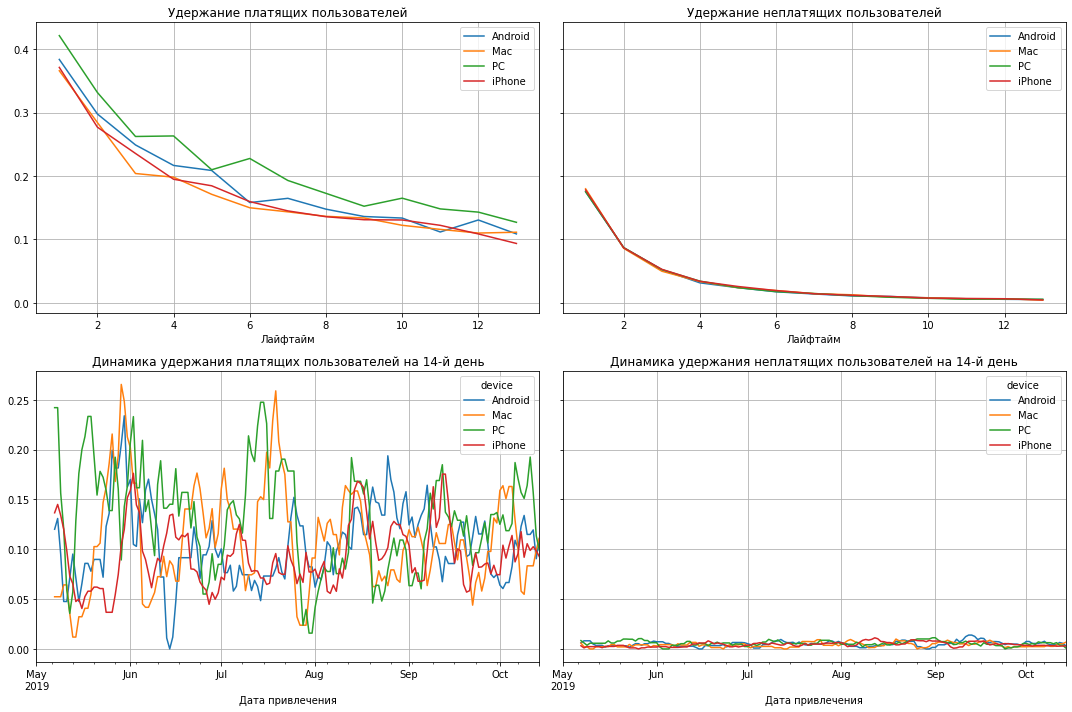

In [38]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание для всех пользователей на разных устройствах стабильное нет явных выбивающихся устройств и колеблется в диапазоне 10-13%. Значит, причина в другом. Перейдем к изучению  окупаемости рекламы с разбивкой по странам.

### Проанализируем окупаемость рекламы с разбивкой по странам

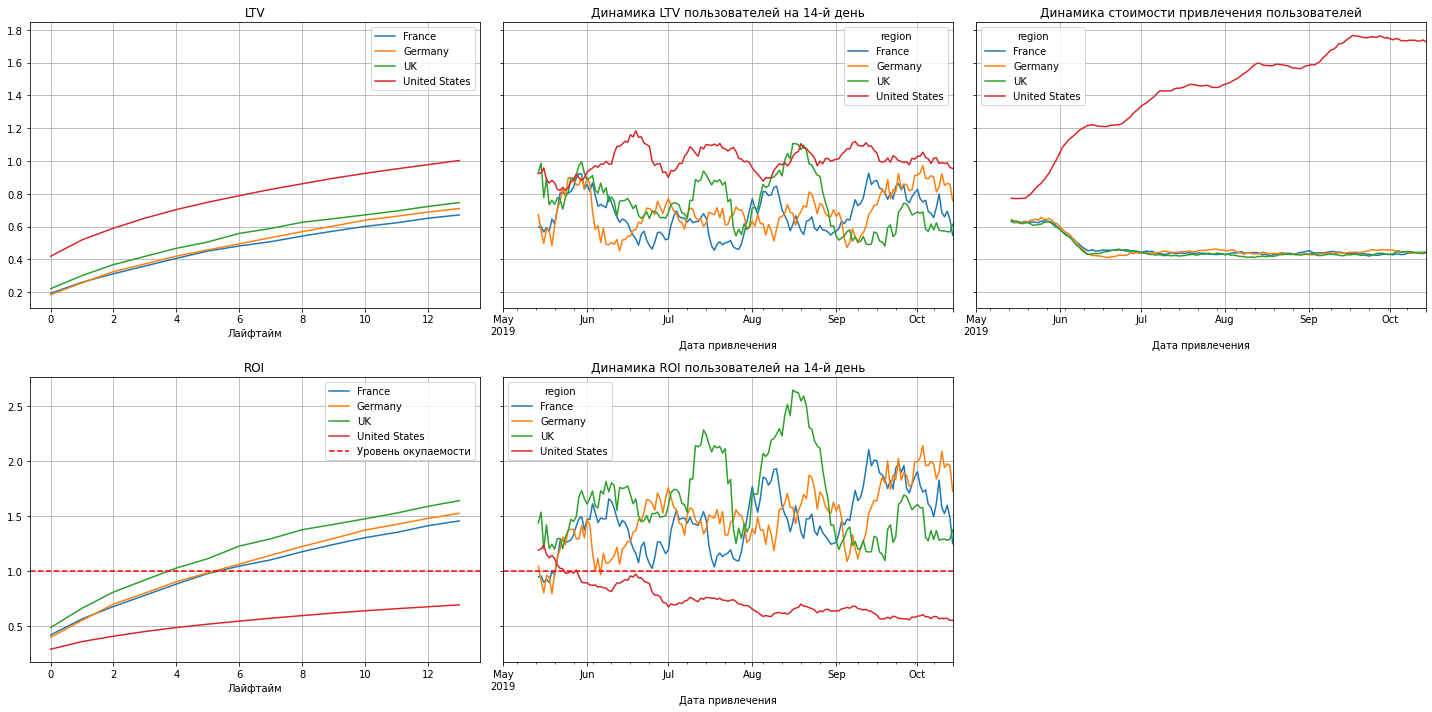

In [39]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1) Сразу заметно, что окупаемость инвестиций в рекламу происходит во всех странах (Франция, Германия, Великобритания). В Великобритании инвестиции окупаются на 164%, в Германии на 152%, а во Франции на 146%. На этом фоне сильно выделяются инвестиции в рекламу в Соединенные Штаты, окупаемость инвестиций составляет 69%, то есть 31% от вложенных инвестиций не ввернулись. Это очень плохо, так как основные пользователи находятся именно в Штатах.

2) Рекламные инвестиции в Соединенные штаты перестали окупаться в середине мая

3) Стоимость привлечения пользователя в США самая высокая и цена растет в отличии от остальных стран.

Изучим конверсию и удержание:

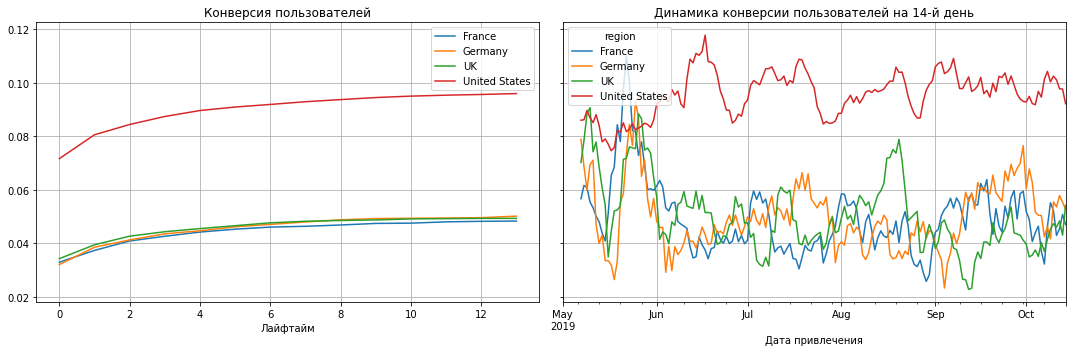

In [40]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Интересно, конверсия в Соединенных Штатах самая лучшая и составляет почти 10 процентов. В то время как другие страны выдают конверсию в районе 5%. Значит, скорее всего причина в удержании. Выведем на экран графики удержания платящих и не платящих пользователей.

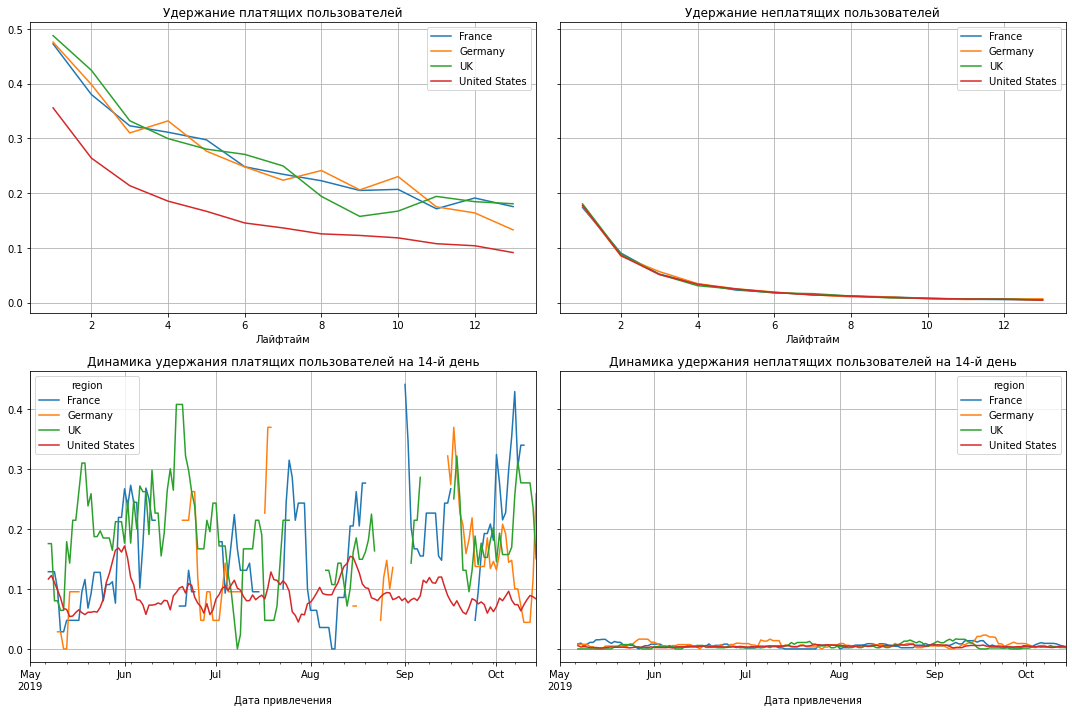

In [41]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

На графике отчетливо видно, что у нас страдает удержание платящих пользователей из США. Удержание платящих пользователей на 14 день из США составляет 9,1%. В то время, как удержание платящих пользователей из других стран колеблется в интервале 13-18%.

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

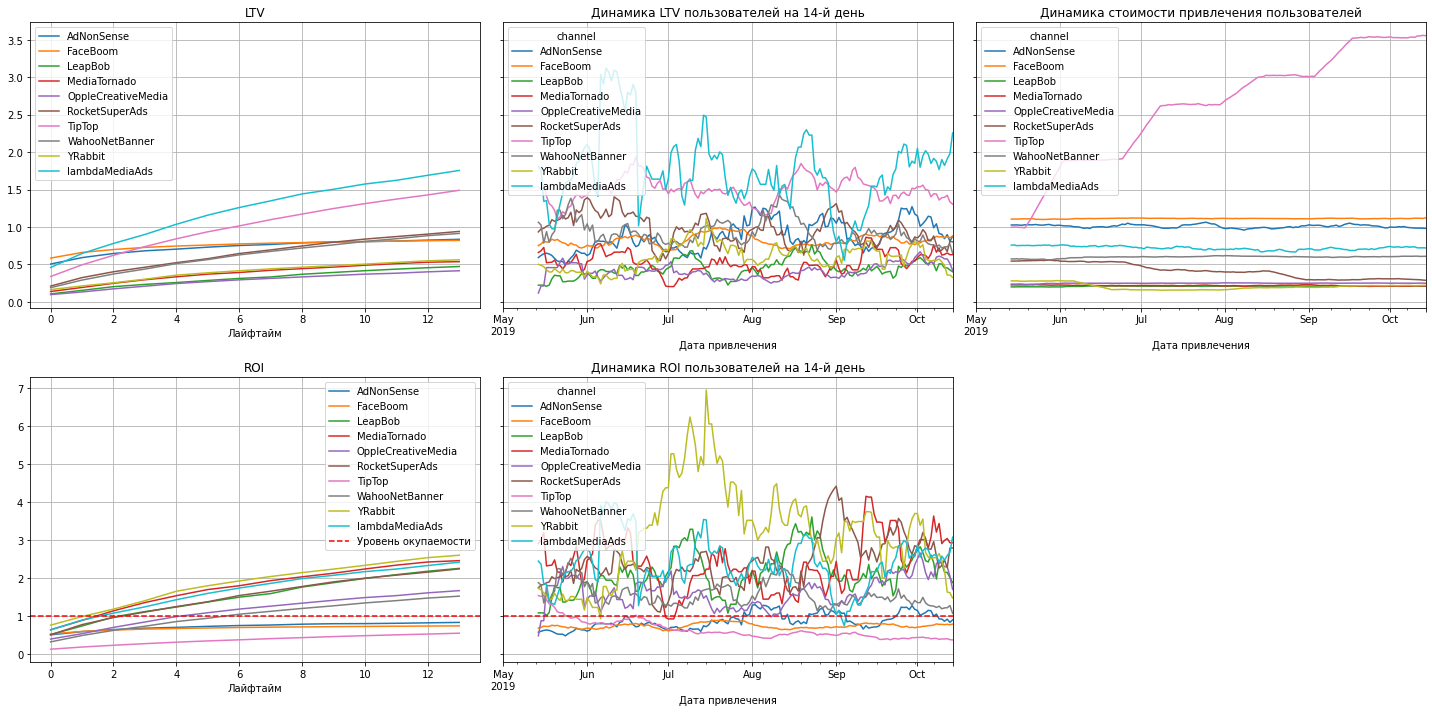

In [42]:
# смотрим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1) Реклама не окупается у трех источников: TipTop, AdNonSense и FaceBoom. Причем самых худший результат окупаемости принадлежит TipTop. У TipTop только 54% окупаемости, FaceBoom - 74% и AdNonSense 83%.

2) Стоимость привлечения пользователя у TipTop самая дорогая и постоянно дорожает, в то время как у остальных сервисов стоимость стабильна.

3) Лучше всего показал себя YRabbit, окупаемость составляет 260%.

Посмотрим на конверсию:

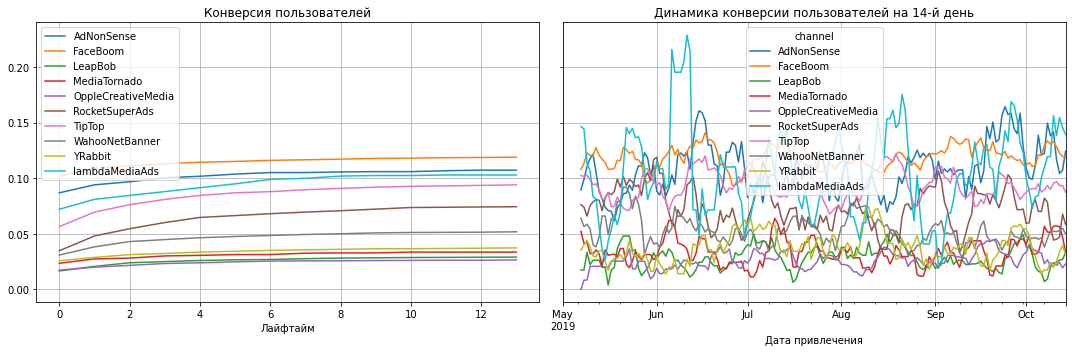

In [43]:
#конверсия по источникам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Самая лучшая конверсия у FaceBoom конверсия составляет 11,9%, следом идет AdNonSense	 - 10,7% и lambdaMediaAds - 10,3%. Худшая конверсия приходится на OppleCreativeMedia - 26,4%.

Посмотрим на удержание:

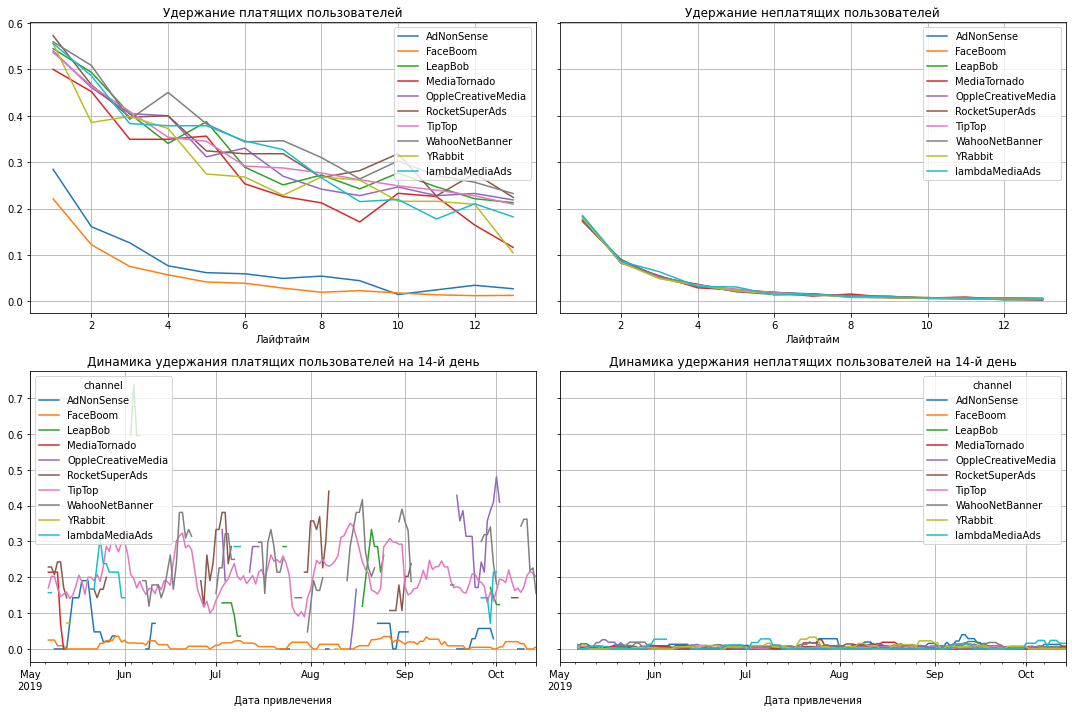

In [44]:
# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Интересно, что самое худшее удержание платящих пользователей приходится на  FaceBoom (0,4%) и AdNonSense (2,7%). Пользователи пришедшие с других площадок показывают себя стабильно и удержание этих пользователей находится в одном диапазоне.

**Рекламные каналы в США**

Мы нашли, что проблема находится в США, поэтому было принятно посмотреть на рекламу по каналам в США по подробнее:

In [45]:
profiles_usa = profiles.query('region == "United States"') #выделим США из таблицы profiiles

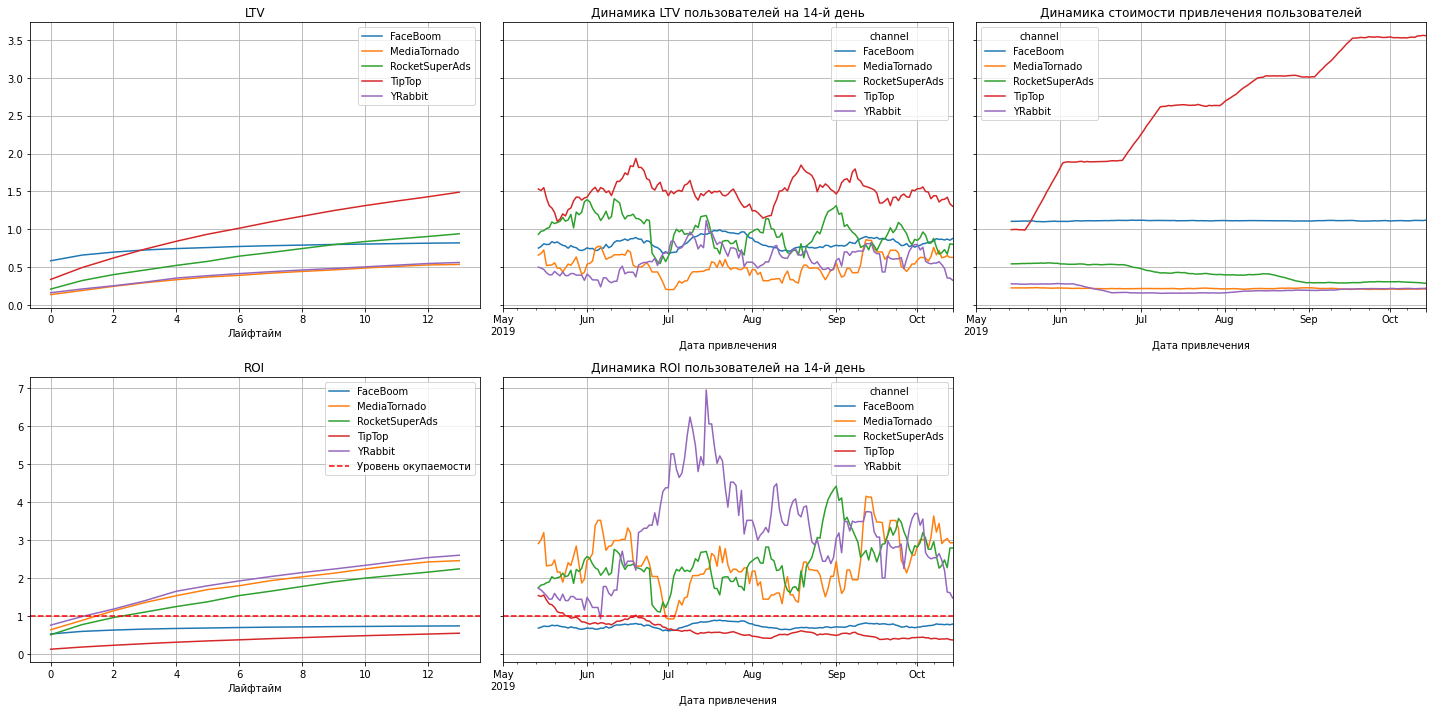

In [46]:
# смотрим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

В США окупаются все рекламные каналы кроме TipTop - 54% окупаемости и FaceBoom - 74%. Лучшая окупаемость у YRabbit - 259%.  У FaceBoom худший LTV. Стоимость привлечения пользователя в TipTop постоянно растет, стоимость привлечения в других каналах стабильна.

Посмотрим на конверсию:

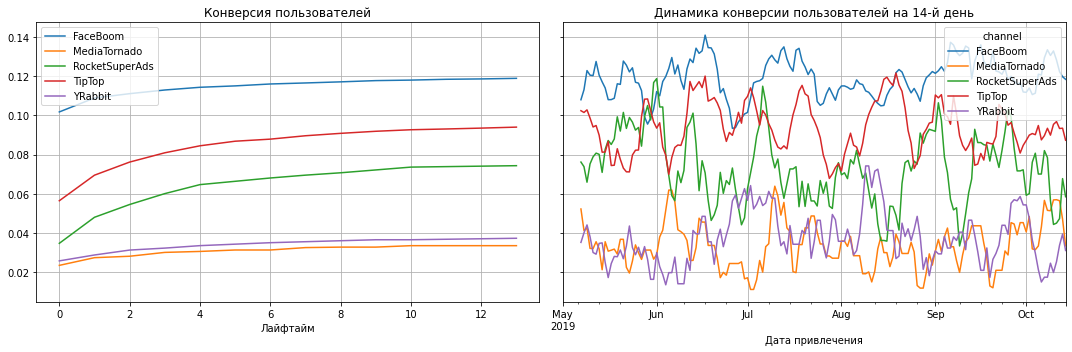

In [47]:
#конверсия по источникам привлечения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Конверсия на всех каналах имеет значительный разброс: У FaceBoom - лучшая конверсия и составляет 11,9%, TipTop - 9,4%, RocketSuperAds - 7,4%, YRabbit - 3,7% и MediaTornado - 3,4%.

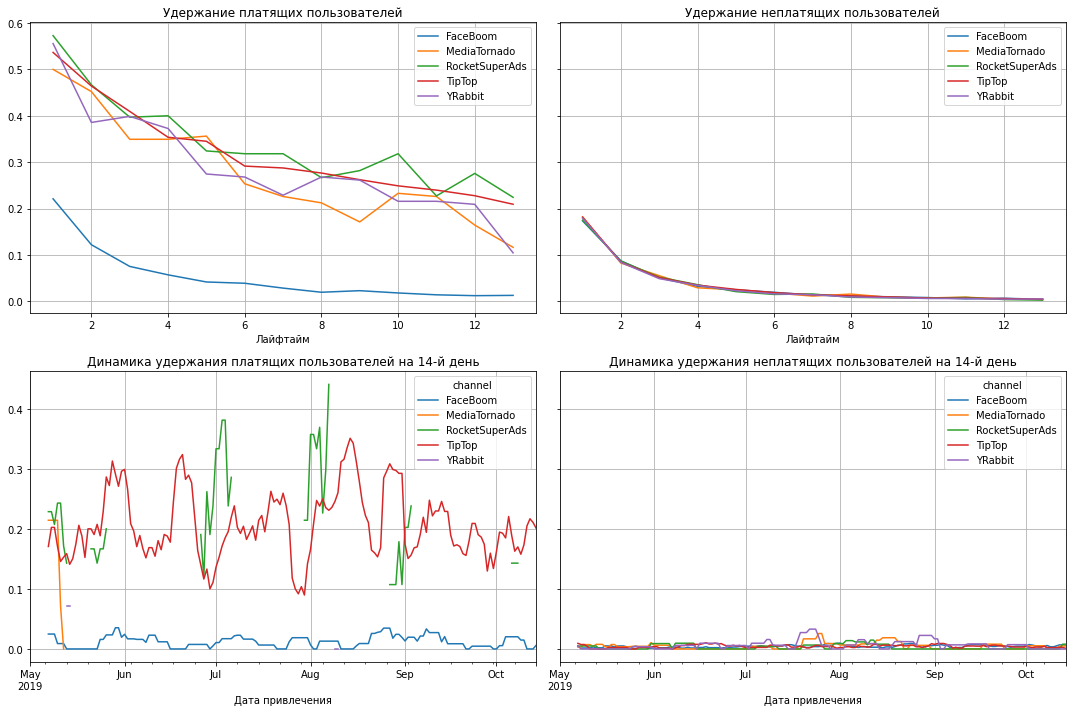

In [48]:
# смотрим удержание с разбивкой по источникам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей  у FaceBoom самое худшее и составялет 1,2%. 

## Выводы

**Основные наблюдения:**

1) Большинство пользователей пришло в приложение из США (100002 человек). Далее, в порядке убывания по количеству пользователей идут следующие страны: Великобритания - 17575 человек, Франция - 17450 человек и Германия - 14981 человек.

2) Рейтинг отношения платящих клиентов ко всем пользователям по региону выглядит следующем образом: США - 6,9%%, Германия - 4.11%, Великобритания - 3,98% и Франция - 3.80%.

3) Самое большое количество пользователей заходят с iPhone - 54479 пользователей, второе по популярности  устройство является Android - 35032 пользователей, следом по популярности идет PC - 30455 пользователей, на последнем месте по популярности устройства идет Mac - 30042  пользователей.

4) Рейтинг долей платящих клиентов по устройствам выглядит следующим образом: Mac 6.36% -платящих пользователей, iPhone - 6.21%, Android - 5.85%, PC - 5.05%.

5) Наибольшее число платящих пользователей пришло с FaceBoom(12.20% платящих от общего числа пришедших), AdNonSense(11.34%) и lambdaMediaAds (10.47%). Наихудшие результаты принадлежат каналам MediaTornado(3.57%), LeapBob (3.06%), и OppleCreativeMedia(2.71%).

6) За изучаемый период было потрачено на рекламу 105497.30 у.е.

7) Тройка лидеров по объему вливания рекламного бюджета выглядит следующим образом: TipTop - забирает 51.90% от всего рекламного бюджета, FaceBoom - 30.75% и WahooNetBanner - всего 4.88% от рекламного бюджета.

8) За изучаемый интервал времени тренд общих расходов на рекламные кампании увеличивается с первого дня.

9) Увеличение расходов на рекламные кампании связано с постоянным увеличением трат на два срвиса - TipToр и FaceBoom. Траты на другие компании является стабильными, держащиеся в одном диапазоне.

10) Средняя стоимость привлечения одного пользователя составляет 1.13 у.е.

11) Самые дорогие пользователи приходят из TipTop стоимость пользователя 2.80 у.е., FaceBoom - 1.11 у.е., AdNonSense - 1.01 у.е. Тройка "дешевых" пользователей выглядит следущем образом: YRabbit - 0.22 у.е., MediaTornado - 0.22 у.е и LeapBob - 0.21 у.е.

12) Стоимость привлечения одного клиента по всем источникам приблизительно стабильная, а вот цена привлечения пользователя из TipTop постоянно и стремительно растет.

13) В США основным каналом привлечения является FaceBoom и TipTop. В Великобритании - OppleCreativeMedia и LeapBob. В Германии - WahooNetBanner и OppleCreativeMedia.
Во Франции - LeapBob и OppleCreativeMedia.

14) Основными девайсами в США являются iPhone и Mac, в Великобритании - PC, Android, в Германии - PC, Android и Франции - PC, Android.

### Причины неэффективности рекламы

Проведя исследование мы пришли к следующим наблюдениям:

1) Общая окупаемость рекламы на 14 день находится на уровне 81%, то есть реклама не окупается и компания теряет 19% вложенных средств.

2) Реклама окупалась до середины июля, затем окупаемость начала стремительно падать

3) Стоимость привлечения пользователей (CAC) не стабилен, стоимость привлечения стремительно растет с середины мая

Для того, чтобы разобраться в причинах провала рекламной кампании был проведен анализ окупаемости рекламы по отдельным характеристикам пользователей: по устройствам, по странам и каналам рекламного привлечения.

**Разбивка по устройствам**

При изучении разбивки по устройствам видно:

1) Владельцы персональных компьютеров окупаются, а вот обладатели продукции от компании Apple (Mac и iphone) и Android, тянут результаты рекламных кампаний вниз. Реклама привлекшая пользователей на PC откупается с показателем 106%, пользователи Android не окупаются, значение окупаемости 90%, Iphone и Mac так же не окупаются с показателями 72% и 73% соответственно. 

2) Пользователи привлеченные на персональных компьютерах в среднем окупаются за исключением интервала с середины июля по август, с сентября реклама перестала окупаться. Пользователи на Android и Iphone перестают окупаться в конце мая - начале июня месяце. Пользователи Mac не окупались практически никогда.

3) Пользователи на всех устройствах конвертируются очень хорошо. Значение конверсии пользователей на Mac составляет 8,7%, обладатели IPhone конвертируются с показателем 8.5%, Android - 7,9% и PC - 6,6%.

4) Удержание для всех пользователей на разных устройствах стабильное

**Разбивка по странам**

1) Инвестиций в рекламу окупаются во всех странах (Франция, Германия, Великобритания) за исключением США. В Великобритании инвестиции окупаются на 164%, в Германии на 152%, а во Франции на 146%. Окупаемость рекламных инвестиций в США составляет 69%, то есть 31% от вложенных инвестиций не ввернулись. Это очень плохо, так как основные пользователи находятся именно в Штатах.

2) Рекламные инвестиции в Соединенные штаты перестали окупаться в середине мая

3) Стоимость привлечения пользователя в США самая высокая и цена растет в отличии от остальных стран.

4) Конверсия в Соединенных Штатах самая лучшая и составляет почти 10 процентов. В то время как другие страны выдают конверсию в районе 5%. 

5) Удержание платящих пользователей на 14 день из США очень низкое и составляет 9,1%. В то время, как удержание платящих пользователей из других стран колеблется в интервале 13-18%.

**Разбивка по рекламным каналам**

1) Реклама не окупается у трех источников: TipTop, AdNonSense и FaceBoom. Причем самых худший результат окупаемости принадлежит TipTop. У TipTop только 54% окупаемости, FaceBoom - 74% и AdNonSense 83%.

2) Стоимость привлечения пользователя у TipTop самая дорогая и постоянно дорожает, в то время как у остальных сервисов стоимость стабильна.

3) Лучше всего показал себя YRabbit, окупаемость составляет 260%.

4) Самая лучшая конверсия у FaceBoom конверсия составляет 11,9%, следом идет AdNonSense - 10,7% и lambdaMediaAds - 10,3%. Худшая конверсия приходится на OppleCreativeMedia - 26,4%.

5) Самое худшее удержание платящих пользователей приходится на FaceBoom (0,4%) и AdNonSense (2,7%). Пользователи пришедшие с других площадок показывают себя стабильно и удержание этих пользователей находится в одном диапазоне.

*Разбивка по США*

6) В США окупаются все рекламные каналы кроме TipTop - 54% окупаемости и FaceBoom - 74%. Лучшая окупаемость у YRabbit - 259%.  У FaceBoom худший LTV среди всех каналов. Стоимость привлечения пользователя в TipTop постоянно растет, стоимость привлечения в других каналах стабильна.

7) Конверсия на всех каналах имеет значительный разброс: У FaceBoom - лучшая конверсия и составляет 11,9%, TipTop - 9,4%, RocketSuperAds - 7,4%, YRabbit - 3,7% и MediaTornado - 3,4%.

8) Удержание платящих пользователей у FaceBoom самое худшее и составялет 1,2%.

### Рекомендации для отдела маркетинга для повышения эффективности

Большинство пользователей пришло из США, однако стоимость привлечения пользователей из США самое дорогое и цена постоянно растет. Так же есть проблема удержания пользователей из этой страны. Но несмотря на это конверсия пользователей из США самая лучшая. Поэтому, предлагается проработать уменьшение затрат на привлечение пользователей. Например, привлекать из более дешевых каналов, так как основные привлечения идут из Faceboom и TipTop. TipTop является самой дорогой по привлечению пользователей и стоимость постоянно растет.

В США очень хорошо себя по окупаемости показал YRabbit, возможно, следует перераспределить часть рекламного бюджета с дорогого TipTop на YRabbit (стоимость привлечения от  туда в 5 раз дешевле)

Стоимость привлечения пользователей на  iPhone и Mac самое дорогое, но это опять же выходит из того, что основная масса пользователей у нас из США, а основными устройствами пользователей в США являются вышеупомянутые девайсы

Удержание пользователей из США самое низкое, нужно над этим поработать. Предложить промоакции, заинтересовать пользователей. 

После более подробного изучения каналов привлечения в США можно сказать, что одним из методов улучшения ситуации может быть повышения качества удержания платящих пользователей, приходящих с FaceBoom. FaceBoom  обладает самой большой конверсией, однако удержание самое наихудшее.   

Как писалось выше часть рекламных бюджетов можно переправить с TipTop. Если исправить ситуацию  с удержанием пользователей пришедших с FaceBoom, то это будет одним из перспективных каналов по привлечению.